In [1]:
library(Seurat)
library(tidyverse)
library(foreach)
library(doParallel)
library(ggpubr)
source("/shareb//zliu//analysis/hires_gastrulation/CHARMtools/Rlibs/plotFun.R")
library(ComplexHeatmap)
options(bedtools.path = "~/miniconda3/envs/py3/bin")
library(bedtoolsr)
options(scipen=999)

celltypeColors = c(
"mitosis"="#bebebe","blood"="#ff9400",
"ExE endoderm"="#fec44f", "ExE ectoderm"="#cab2d6", 
"epiblast and PS"="#addd8e",
#neural
"neural ectoderm"="#AECBE6","NMP"="#96B9DB","neural tube"="#7EA8D0","notochord"="#6696C6","radial glias"="#4F85BB","oligodendrocytes and progenitors"="#3773B1","early neurons"="#1F62A6","schwann cell precursors"="#08519C",
#mesodermal
"early mesoderm"="#FC9272","ExE mesoderm"="#EF7F64","early mesenchyme"="#E36C57","intermediate mesoderm"="#D6594A", "myocytes"="#CA473C","mix late mesenchyme"="#BD342F",
"endoderm"="#fe9929","epithelial cells"="#fa9fb5"
)
cellcyclecolors = c("G0"="#762a83","G1"="#c2a5cf","Early-S"="#99d8c9","Mid-S"="#66c2a4","Late-S"="#41ae76","G2"="#238b45","M"="#ea6e34")

hires <- readRDS("../../hires_mouse_emb_dev.new.rds")

Registered S3 method overwritten by 'spatstat.geom':
  method     from
  print.boxx cli 

Attaching SeuratObject

── Attaching packages ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘foreach’


The followin

In [61]:
# functions
overlap_ratio <- function(bedpe,bed){
    bed <- bed %>% select(1:3)
    names(bed) <- c("chrom","start","end")
    
    bed1_l <- bedpe %>% select(1:3)
    bed1_r <- bedpe %>% select(4:6)

    names(bed1_l) <- c("chrom","start","end")
    names(bed1_r) <- c("chrom","start","end")
    names(bed) <- c("chrom","start","end")
    
    bed1_l_intersect <- valr::bed_intersect(bed1_l%>% mutate(id = row_number()),bed)  %>% select(1:4) %>% unique()
    bed1_r_intersect <- valr::bed_intersect(bed1_r%>% mutate(id = row_number()),bed)  %>% select(1:4) %>% unique()
    
    intersected <- full_join(bed1_l_intersect,bed1_r_intersect,by="id.x")
    a=dim(intersected %>% filter(chrom.x == chrom.y))[1]
    b=dim(intersected)[1]
    c=dim(bedpe)[1]
    return(c(a/c,b/c))
}

dynamic_postprocess <- function(dynamics,fdr_threshold = 0.05){
    temp <- dynamics %>%  group_by(gene,gadi,type) %>% mutate(norm_value = (value - min(fitted_raw))/(max(fitted_raw) - min(fitted_raw))) %>% 
     select(-c(value,fitted_raw,fitted,high,low)) %>% group_by(type) %>% mutate(id = row_number()) %>% spread(type,norm_value)  %>% mutate(residue = GADI - RNA) %>% na.omit()  %>%
      group_by(gene,gadi) 
    testres = temp %>% group_by(gene,gadi) %>% summarise(residual = mean(GADI-RNA),pv = t.test(GADI-RNA,mu=0)$p.value,t=t.test(GADI-RNA,mu=0)$statistic) %>% ungroup()
    #testres = temp %>% group_by(gene,gadi) %>% summarise(residual = mean(GADI-RNA),pv = wilcox.test(GADI-RNA,mu=0)$p.value,t=t.test(GADI-RNA,mu=0)$statistic) %>% ungroup()
    testres <- testres  %>% mutate(fdr = p.adjust(pv,method="BH")) %>% 
        mutate(type = ifelse(sign(t)==1,"early","lag"),sigtype = ifelse(fdr < fdr_threshold,"sig","not")) 
    testres %>% mutate(test_type = ifelse(sigtype == "sig",type,"notSig"))%>% mutate(gaditype = str_extract(gadi,"neg|pos"),gadi=str_remove_all(gadi,"pos|neg")) %>% 
        separate(gadi,into = c("chrom","bin1","bin2")) %>% mutate(bin1 = as.numeric(bin1),bin2 = as.numeric(bin2)) %>% 
        mutate(start1=bin1 - 10000,start2=bin2-10000,end1 = bin1 + 10000,end2 = bin2+ 10000,chrom1 = chrom,chrom2 = chrom) %>% 
        select(chrom1,start1,end1,chrom2,start2,end2,gaditype,test_type,residual,pv,fdr,gene) %>% ungroup() -> testres
    return(testres)
}

library(circlize)

plot_cluster_residual <- function(heatmapdata_ecto_neg){
    col_fun = colorRamp2(c(0, 0.5, 1), c("#f7fbff","#9ecae1","#084594"))
    col_fun1 = colorRamp2(c(-1, 0, 1), rev(c("#ff0000","#ebe9ef","#0000ff")))
    #GADI heatmap
    gadi_heatmap_data <- heatmapdata_ecto_neg %>% select(gene,pseudotime,GADI) %>% spread(pseudotime,GADI) %>% column_to_rownames("gene") 
    gadi_heatmap <- gadi_heatmap_data %>% 
    Heatmap(cluster_columns = F,cluster_rows = F,show_column_names = F,show_row_names = F,column_title = "GADI",heatmap_legend_param = list(title = "GADI"),col = col_fun) 
#RNA heatmap
    RNA_heatmap_data <- heatmapdata_ecto_neg %>% select(gene,pseudotime,RNA) %>% spread(pseudotime,RNA) %>% column_to_rownames("gene") 
    RNA_heatmap <- RNA_heatmap_data %>% 
    Heatmap(cluster_columns = F,cluster_rows = F,show_column_names = F,show_row_names = F,column_title = "RNA",heatmap_legend_param = list(title = "RNA"),col = col_fun) 
    #GADI heatmap
    sorts <- RNA_heatmap_data  %>% t() %>% as.data.frame %>% rownames_to_column("ptime") %>% gather(name,value,-ptime) %>% group_by(name) %>% arrange(desc(value)) %>% slice(1) %>% mutate(ptime = as.numeric(ptime)) %>% arrange(ptime) %>% pull(name)
    Residual_heatmap_data <- heatmapdata_ecto_neg %>% select(gene,pseudotime,residual) %>% spread(pseudotime,residual) %>% column_to_rownames("gene") 
    Residual_heatmap <- Residual_heatmap_data %>% 
    Heatmap(cluster_columns = F,cluster_rows = FALSE,show_column_names = F,
    row_km = 3 ,row_km_repeats = 500, 
    show_row_names = T,column_title = "Residuals",
    heatmap_legend_param = list(title = "Residuals"),col=col_fun1,
    row_order = sorts
    ) 


    options(repr.plot.width=8,repr.plot.height=6 ,repr.plot.res=200)
    draw(Residual_heatmap+gadi_heatmap + RNA_heatmap)   
}

calc_dynamic <-  function(object,gene,gadi,key,slot1="mc_sct",slot2="gadis",correlation = "pos"){
    RNA_temp <- object[[slot1]]@data[gene,]
    if(correlation=="pos"){
        GADI_temp <- object[[slot2]]@data[gadi,]
    }
    else{
        GADI_temp <- -object[[slot2]]@data[gadi,]
    }
    tempData <- cbind(RNA_temp,GADI_temp,object[[]] %>% select(all_of(key)) %>% pull(1)) %>% as.data.frame() 
    names(tempData) <- c("RNA","GADI","pseudotime")
    #tempData <- tempData %>% filter(pseudotime > 0.4)
    tempData <- tempData %>% gather(type,value,-pseudotime)
    tempData[is.na(tempData)] <- 0

    tempData <- tempData %>% group_by(type) %>% mutate(fitted_raw = predict(loess(value ~ pseudotime), se=T)$fit,fitted = (fitted_raw - min(fitted_raw))/(max(fitted_raw)-min(fitted_raw)),
                                          high = fitted + qt(0.975,predict(loess(value ~ pseudotime), se=T)$df)*predict(loess(value ~ pseudotime), se=T)$se, high = (high - min(high))/(max(high)-min(high)),
                                          low = fitted - qt(0.975,predict(loess(value ~ pseudotime), se=T)$df)*predict(loess(value ~ pseudotime), se=T)$se, low = (low - min(low))/(max(low)-min(low)))
    return(tempData %>% mutate(gene =gene,gadi=gadi))
}

In [3]:
hires <- subset(hires,subset = celltype != "mitosis" & celltype != "ExE ectoderm" & celltype != "ExE endoderm" & cellcycle_threshold != "M" & celltype != "blood")
DefaultAssay(hires) <- "SCT"
Idents(hires)<- hires$celltype
neuron_markers <- FindMarkers(hires,`ident.1` = "early neurons",only.pos = T) %>% filter(p_val_adj < 0.01)
mesenchyme_markers <- FindMarkers(hires,`ident.1` = "mix late mesenchyme",only.pos = T) %>% filter(p_val_adj < 0.01)

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from cpg_umap_ to cpgumap_”
Warning message:
“Cannot add objects with duplicate keys (offending key: cpgumap_) setting key to original value 'cpg_umap_'”


In [4]:
dim(neuron_markers)
dim(mesenchyme_markers)

[1] 695   5

[1] 524   5

In [5]:
mm10 <- read_tsv("/share/Data/public/ref_genome/mouse_ref/M23/raw_data/gene.bed",col_names = F)
names(mm10) <- c("chrom","start","end","id","gene","strand")
mm10 <- mm10 %>% mutate(length = end - start) %>% arrange(desc(length)) %>% group_by(gene) %>% slice(1) %>% ungroup() %>% valr::bed_sort() %>% select(-length)

Rows: 55335 Columns: 6
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (4): X1, X4, X5, X6
dbl (2): X2, X3

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# load data

In [6]:
alldi_raw <- read_tsv("alldis.tsv.gz")

Rows: 5689793 Columns: 13
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (4): chrom1, chrom2, pos, celltype
dbl (9): start1, end1, start2, end2, pv, FDR, diff, mat1_mean_all, mat2_mean...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [15]:
random_bedpe <- read_tsv("alltestable.tsv.gz")

Rows: 4727874 Columns: 6
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): chrom1, chrom2
dbl (4): start1, end1, start2, end2

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [16]:
alldi <- read_tsv("alldis.filtered.tsv.gz")

Rows: 694384 Columns: 13
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (4): chrom1, chrom2, pos, celltype
dbl (9): start1, end1, start2, end2, pv, FDR, diff, mat1_mean_all, mat2_mean...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [17]:
allgadi <- read_tsv("hires_allcor.500k.tsv.gz")
allgadi %>% group_by(name,pos) %>% slice(1) %>% ungroup() -> allgadi
allgadi <- allgadi %>% mutate(fdr_cor = p.adjust(pv,method="BH")) %>% filter(fdr_cor < 0.01)

allgadi_bedpe <- allgadi %>%mutate(pos1=pos) %>% separate(pos1,into = c("chrom","bin1","bin2")) %>% mutate(bin1 = as.numeric(bin1),bin2 = as.numeric(bin2)) %>% 
        mutate(start1=bin1 - 10000,start2=bin2-10000,end1 = bin1 + 10000,end2 = bin2+ 10000,chrom1 = chrom,chrom2 = chrom)%>% 
    select(chrom1,start1,end1,chrom2,start2,end2,name,cor,pv,fdr_cor,pos)
allgadi_bedpe <- allgadi_bedpe %>% group_by(name) %>% mutate(count = n()) %>% filter(count > 10) %>% ungroup() %>% select(-count) 

Rows: 1174515 Columns: 4
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): name, pos
dbl (2): cor, pv

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [69]:
allgadi_bedpe %>% mutate(GADI_id = paste0("GADI_",row_number())) -> allgadi_bedpe
allgadi_bedpe%>% write_tsv("hires_emb_gadi.tsv.gz")

In [20]:
mc_hires <- readRDS("hires_emb_metacell.rds")

# Calculate residual

In [23]:
ectoderm <- subset(mc_hires,subset = celltype %in% c("epiblast and PS","neural ectoderm","neural tube","radial glias","notochord","oligodendrocytes and progenitors","early neurons"))
mesoderm <- subset(mc_hires,subset = celltype %in% c("epiblast and PS","early mesenchyme","myocytes","ExE mesoderm","early mesoderm","intermediate mesoderm","mix late mesenchyme"))

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from mcsct_pca_ to mcsctpca_”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from mcsct_umap_ to mcsctumap_”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from mcsct_pca_ to mcsctpca_”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from mcsct_umap_ to mcsctumap_”


In [26]:
genes_table <- allgadi_bedpe %>% filter(name %in% rownames(neuron_markers)) 

start = Sys.time()
registerDoParallel(150)
ecto_dir_gene_dynamic_neg <- foreach(gene = genes_table%>% filter(cor < 0) %>% pull(name),gadi = genes_table%>% filter(cor < 0) %>% pull(pos),.combine = "rbind", .errorhandling = "stop") %dopar% {
    calc_dynamic(ectoderm,gene,gadi,"sct_pseudotime",correlation="neg",slot2="mc_di") %>% mutate(gadi = paste0(gadi,"neg"))
}
ecto_dir_gene_dynamic_pos <- foreach(gene = genes_table%>% filter(cor > 0) %>% pull(name),gadi = genes_table%>% filter(cor > 0) %>% pull(pos),.combine = "rbind", .errorhandling = "stop") %dopar% {
    #gc()
    calc_dynamic(ectoderm,gene,gadi,"sct_pseudotime",correlation="pos",slot2="mc_di") %>% mutate(gadi = paste0(gadi,"pos"))
}
residuals_dynamic <- rbind(ecto_dir_gene_dynamic_neg,ecto_dir_gene_dynamic_pos)
end = Sys.time()
end -start

residuals_dynamic %>% saveRDS("residuals_dynamic.neu.rds.gz")

Time difference of 36.09015 mins

In [27]:
genes_table <- allgadi_bedpe %>% filter(name %in% rownames(mesenchyme_markers)) 

start = Sys.time()
meso_dir_gene_dynamic_neg <- foreach(gene = genes_table%>% filter(cor < 0) %>% pull(name),gadi = genes_table%>% filter(cor < 0) %>% pull(pos),.combine = "rbind", .errorhandling = "stop") %dopar% {
    #gc()
    calc_dynamic(mesoderm,gene,gadi,"sct_pseudotime",correlation="neg",slot2="mc_di") %>% mutate(gadi = paste0(gadi,"neg"))
}
meso_dir_gene_dynamic_pos <- foreach(gene = genes_table%>% filter(cor > 0) %>% pull(name),gadi = genes_table%>% filter(cor > 0) %>% pull(pos),.combine = "rbind", .errorhandling = "stop") %dopar% {
    #gc()
    calc_dynamic(mesoderm,gene,gadi,"sct_pseudotime",correlation="pos",slot2="mc_di") %>% mutate(gadi = paste0(gadi,"pos"))
}
residuals_dynamic <- rbind(meso_dir_gene_dynamic_neg,meso_dir_gene_dynamic_pos)
end = Sys.time()
end -start

residuals_dynamic %>% saveRDS("residuals_dynamic.mesen.rds.gz")

Time difference of 53.93047 mins

# generate stat

In [29]:
print('Statistics of \"Find Marker\" on emb cells')
print(paste0("Total tested loci: ",dim(random)[1]))
print(paste0("DI in at least one celltype: ",alldi_raw %>% pull(pos) %>% unique() %>% length()))
print(paste0("Top DI in at least one celltype: ",alldi %>% pull(pos) %>% unique() %>% length()))

[1] "Statistics of \"Find Marker\" on emb cells"
[1] "Total tested loci: 4727874"
[1] "DI in at least one celltype: 2861012"
[1] "Top DI in at least one celltype: 535780"


In [30]:
pos_di_number = alldi %>% filter(diff>0)%>% pull(pos) %>% unique() %>% length()
neg_di_number = alldi %>% filter(diff<0)%>% pull(pos) %>% unique() %>% length()
print(paste0("Among all top di ",pos_di_number," is positive(less interaction in given celltype)"))
print(paste0("Among all top di ",neg_di_number," is positive(more interaction in given celltype)"))

[1] "Among all top di 252243 is positive(less interaction in given celltype)"
[1] "Among all top di 341716 is positive(more interaction in given celltype)"


In [33]:
print(paste0("All di gene pair: ",dim(allgadi_bedpe)[1]))
print(paste0("GADI contain ",length(allgadi_bedpe%>% pull(pos) %>% unique())," DI and ",
             length(allgadi_bedpe %>% pull(name) %>% unique())," genes"))
print(paste0(length(allgadi_bedpe %>% filter(cor < 0)%>% pull(pos) )," is neg corr(more interactions when expression) and ",
             length(allgadi_bedpe %>% filter(cor > 0)%>% pull(pos) )," is pos corr(less interactions when expression)"))

[1] "All di gene pair: 390252"
[1] "GADI contain 223607 DI and 1955 genes"
[1] "268092 is neg corr(more interactions when expression) and 122160 is pos corr(less interactions when expression)"


Warning message:
“Using `bins = 30` by default. Pick better value with the argument `bins`.”


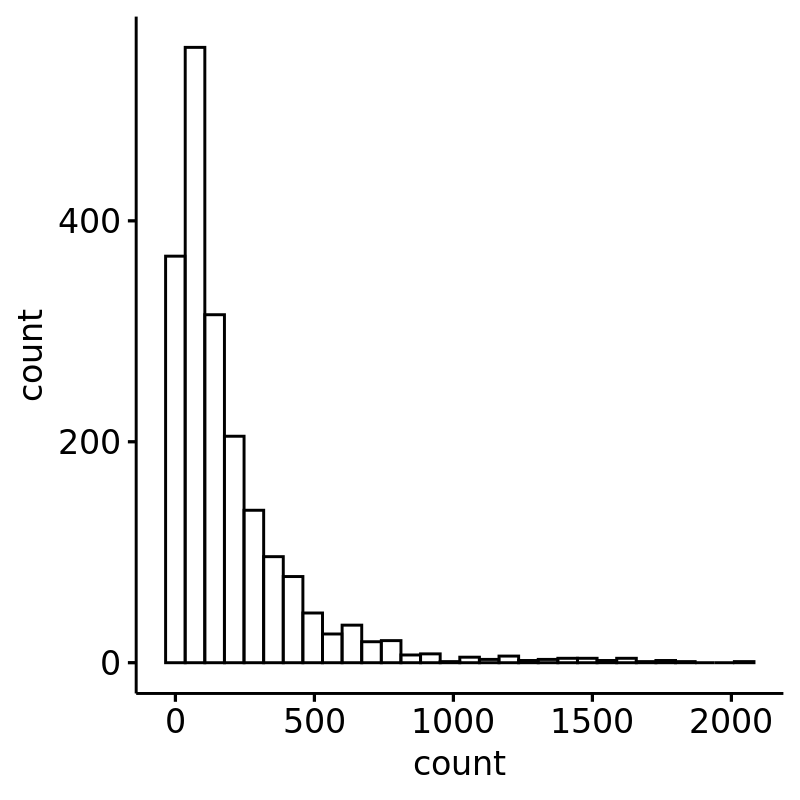

In [34]:
options(repr.plot.height = 4, repr.plot.width = 4,repr.plot.res = 200)
allgadi_bedpe %>% group_by(name) %>% summarise(count = n()) %>% gghistogram(x="count")

Warning message:
“Using `bins = 30` by default. Pick better value with the argument `bins`.”


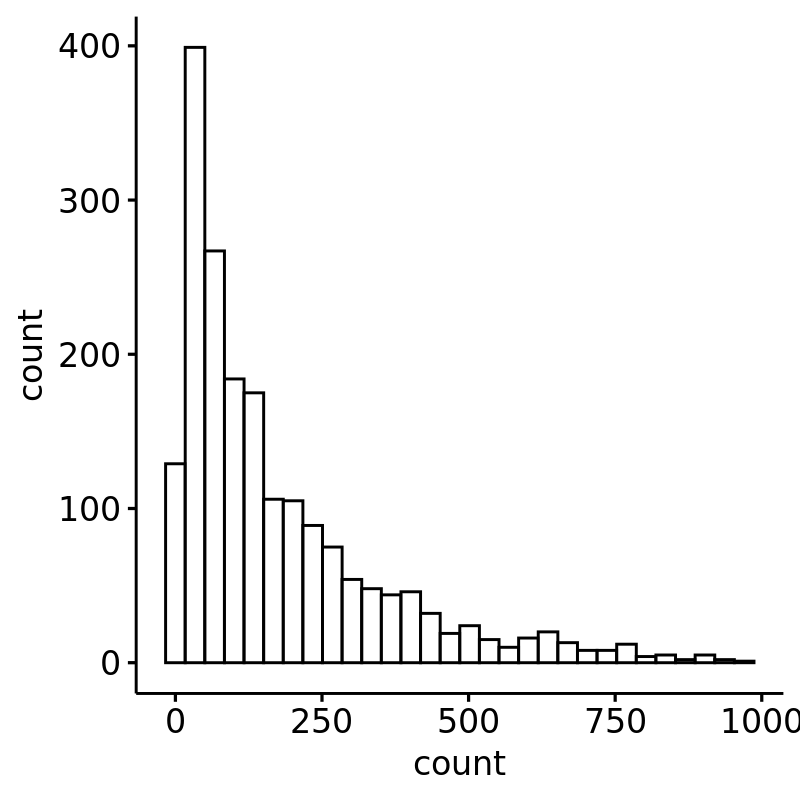

In [35]:
options(repr.plot.height = 4, repr.plot.width = 4,repr.plot.res = 200)
allgadi_bedpe %>% group_by(name) %>% summarise(count = n()) %>% filter(count > 10,count < 1000) %>% gghistogram(x="count")

In [40]:
allgadi_bedpe %>% pull(pos) %>% unique() %>% length()

[1] 223607

In [41]:
allgadi_bedpe %>% group_by(pos) %>% summarise(count = n()) %>% group_by(count) %>% summarise(count_loci = n(),percent = count_loci / 223607) %>% mutate(type = ifelse(count>5,"cluster","else"))

count,count_loci,percent,type
<int>,<int>,<dbl>,<chr>
1,136474,0.61032973029,else
2,54154,0.24218383145,else
3,17315,0.07743496402,else
4,6767,0.03026291663,else
5,2897,0.01295576614,else
6,1945,0.00869829656,cluster
7,1073,0.00479859754,cluster
8,1866,0.00834499814,cluster
9,112,0.00050087877,cluster


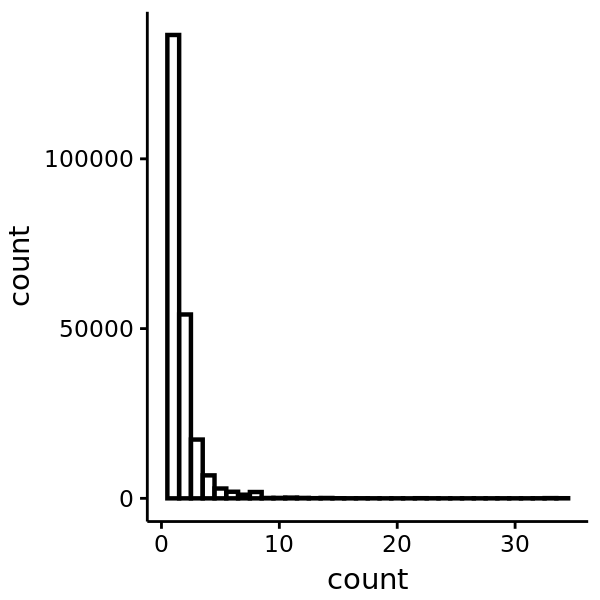

In [88]:
options(repr.plot.height = 2, repr.plot.width = 2,repr.plot.res = 300)
#p <- allgadi_bedpe %>% group_by(pos) %>% summarise(count = n()) %>% gghistogram(x="count",bins=34) + theme_Publication()
p
p %>% ggsave(filename = "plots/gene_per_di_gadi.pdf",width = 1.5,height=1.5,dpi=300)

In [43]:
allgadi_bedpe %>% group_by(pos) %>% summarise(count = n()) %>% group_by(count) %>% summarise(count_loci = n(),percent = count_loci / 226868) %>% mutate(type = ifelse(count>5,"cluster","else")) %>% filter(type == "cluster") %>% pull(percent) %>% sum()

[1] 0.0264471

In [44]:
mesen_dynamics <- readRDS("/shareb/zliu/analysis/hires_mouse_dev/figure3_related_new/di_new_emb/residuals_dynamic.mesen.rds.gz")
neural_dynamics <- readRDS("/shareb/zliu/analysis/hires_mouse_dev/figure3_related_new/di_new_emb/residuals_dynamic.neu.rds.gz")

In [62]:
neural_testRes <- dynamic_postprocess(neural_dynamics)
mesen_testRes <- dynamic_postprocess(mesen_dynamics)

`summarise()` has grouped output by 'gene'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'gene'. You can override using the `.groups` argument.


In [63]:
mesen_testRes %>% dim()
neural_testRes %>% dim()

[1] 104515     12

[1] 90322    12

# Stat

In [70]:
total <- neural_testRes %>% dim()
posnum <- neural_testRes %>% filter(residual > 0) %>% dim()
negnum <- neural_testRes %>% filter(residual < 0) %>% dim()
print(total[1])
print(posnum[1])
print(negnum[1])
print(paste0("posratio = ",posnum[1]/total[1]))


total <- mesen_testRes %>% dim()
posnum <- mesen_testRes %>% filter(residual > 0) %>% dim()
negnum <- mesen_testRes %>% filter(residual < 0) %>% dim()

print(total[1])
print(posnum[1])
print(negnum[1])
print(paste0("posratio = ",posnum[1]/total[1]))

[1] 90322
[1] 56721
[1] 33601
[1] "posratio = 0.62798653705631"
[1] 104515
[1] 69217
[1] 35298
[1] "posratio = 0.662268573888915"


In [72]:
neural_testRes %>% pull(gene) %>% unique() %>% length()
mesen_testRes %>% pull(gene) %>% unique() %>% length()

[1] 398

[1] 325

In [73]:
neural_testRes %>% select(1:6) %>% unique() %>% dim()
mesen_testRes %>% select(1:6) %>% unique() %>% dim()

[1] 72605     6

[1] 75581     6

In [74]:
neural_testRes %>% group_by(test_type) %>% summarise(count = n())
mesen_testRes %>% group_by(test_type) %>% summarise(count = n())

test_type,count
<chr>,<int>
early,13334
lag,4272
notSig,72716


test_type,count
<chr>,<int>
early,24242
lag,3768
notSig,76505


Warning message:
“Using `bins = 30` by default. Pick better value with the argument `bins`.”
Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


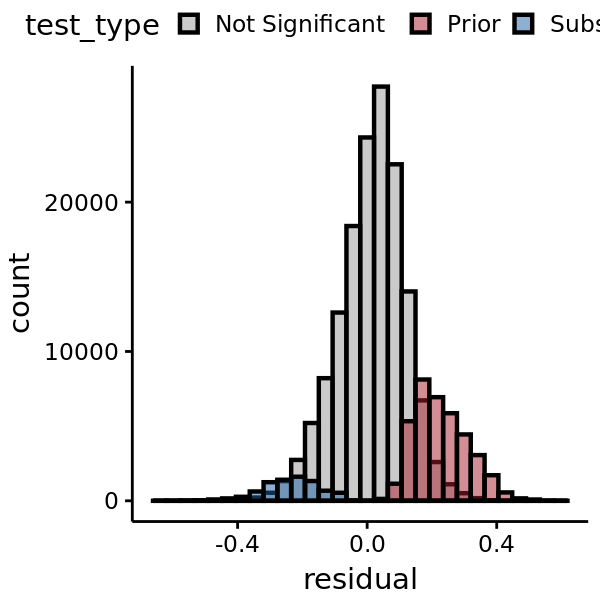

In [82]:
options(repr.plot.width = 2,repr.plot.height=2,repr.plot.res= 300)
p <- rbind(neural_testRes,mesen_testRes) %>% mutate(test_type = ifelse(fdr < 0.05,test_type,"Not Significant"))%>% 
    mutate(test_type=ifelse(test_type == "early","Prior",test_type)) %>% 
    mutate(test_type=ifelse(test_type == "lag","Subsequent",test_type)) %>%
    gghistogram(x="residual",fill="test_type",palette = c("#969696","#a81e2c","#2161a2")) + theme_Publication()
p
p %>% ggsave(filename = "plots/plotshisto_earlylag.pdf",width = 2,height = 1.5,dpi=300)

In [93]:
rbind(neural_testRes%>% mutate(lineage = "EN"),mesen_testRes%>% mutate(lineage = "MLM"))%>% 
 mutate(gaditype = ifelse(gaditype == "neg","Pos.corr.","Neg.corr."),
       test_type = ifelse(test_type == "early","Prior",ifelse(test_type=="lag","Succeeding","Not Significant"))) %>% write_tsv("residual.tsv.gz")

In [94]:
rbind(neural_testRes%>% mutate(lineage = "EN"),mesen_testRes%>% mutate(lineage = "MLM"))%>% 
 mutate(gaditype = ifelse(gaditype == "neg","Pos.corr.","Neg.corr."),
       test_type = ifelse(test_type == "early","Prior",ifelse(test_type=="lag","Succeeding","Not Significant")))

chrom1,start1,end1,chrom2,start2,end2,gaditype,test_type,residual,pv,fdr,gene,lineage
<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
chr13,27290000,27310000,chr13,27990000,28010000,Pos.corr.,Not Significant,-0.08208606,0.2679699940,0.479582821,2610307P16Rik,EN
chr13,27310000,27330000,chr13,28010000,28030000,Pos.corr.,Not Significant,-0.06436583,0.3583830232,0.574035670,2610307P16Rik,EN
chr13,28250000,28270000,chr13,29030000,29050000,Neg.corr.,Not Significant,-0.07582363,0.3093410898,0.524001911,2610307P16Rik,EN
chr13,28250000,28270000,chr13,29050000,29070000,Neg.corr.,Not Significant,-0.04429305,0.4616317043,0.666754598,2610307P16Rik,EN
chr13,28250000,28270000,chr13,29070000,29090000,Neg.corr.,Not Significant,-0.05577561,0.3438962388,0.559261723,2610307P16Rik,EN
chr13,28250000,28270000,chr13,29090000,29110000,Neg.corr.,Not Significant,-0.02392935,0.5189150515,0.713461789,2610307P16Rik,EN
chr13,28270000,28290000,chr13,28490000,28510000,Neg.corr.,Not Significant,-0.04490550,0.3884883498,0.603256967,2610307P16Rik,EN
chr13,28270000,28290000,chr13,29030000,29050000,Neg.corr.,Not Significant,-0.05497231,0.4241383152,0.635760508,2610307P16Rik,EN
chr13,28270000,28290000,chr13,29050000,29070000,Neg.corr.,Not Significant,-0.04375049,0.3808212392,0.596023843,2610307P16Rik,EN
